## Bike Sharing Demand Project

Input Features: ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek','hour'] Target Feature: [log1p('count')]

Objective: We are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period (Ref: Kaggle.com)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import mean_squared_log_error

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, I've written the code to load and prepare the data. 

In [2]:
data_path = 'Bike-Sharing-Dataset'

submission = pd.read_csv('sampleSubmission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
#train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
#train['minute'] = train['datetime'].dt.minute
#train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek



test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
#test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
#test['minute'] = test['datetime'].dt.minute
#test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek


print('Train data set size: {}'.format(train.shape))
print('Test data set size: {}'.format(test.shape))

print(train.dtypes)
print(test.dtypes)
print('N/A values in train data: \n{}'.format(train.isnull().sum()))

print('Randomly selected 5 rows from the dataframe:')
train.sample(frac=1).head(5)

Train data set size: (10886, 16)
Test data set size: (6493, 13)
datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
year                   int64
month                  int64
hour                   int64
dayofweek              int64
dtype: object
datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
year                   int64
month                  int64
hour                   int64
dayofweek              int64
dtype: object
N/A values in train data: 
datetime      0
season        0
holiday 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
6997,2012-04-09 21:00:00,2,0,1,3,19.68,23.485,41,27.9993,14,151,165,2012,4,21,0
10146,2012-11-08 04:00:00,4,0,1,2,12.30,14.395,45,19.0012,1,9,10,2012,11,4,3
1798,2011-05-01 20:00:00,2,0,0,2,18.86,22.725,82,0.0000,35,86,121,2011,5,20,6
8254,2012-07-05 07:00:00,3,0,1,1,31.16,34.850,55,0.0000,27,316,343,2012,7,7,3
8365,2012-07-09 22:00:00,3,0,1,2,29.52,33.335,58,7.0015,35,189,224,2012,7,22,0


In [4]:
train.describe()


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,11.541613,3.013963
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,6.915838,2.004585
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,6.000000,1.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,12.000000,3.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,18.000000,5.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,23.000000,6.000000


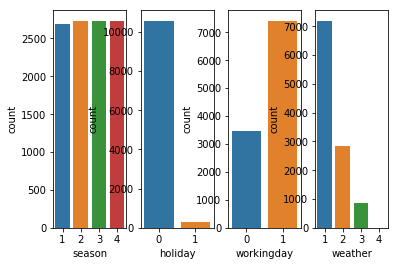

In [5]:
i=0
for column in ['season', 'holiday', 'workingday', 'weather']:
    plt.subplot(1, 4, i+1)
    sn.countplot(column, data=train)
    i = i+1

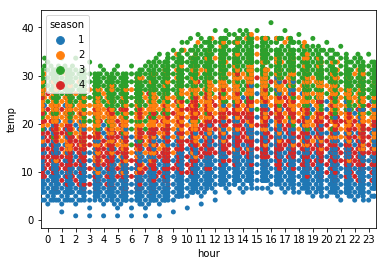

In [6]:
sn.swarmplot(x='hour', y='temp', hue='season', data=train)


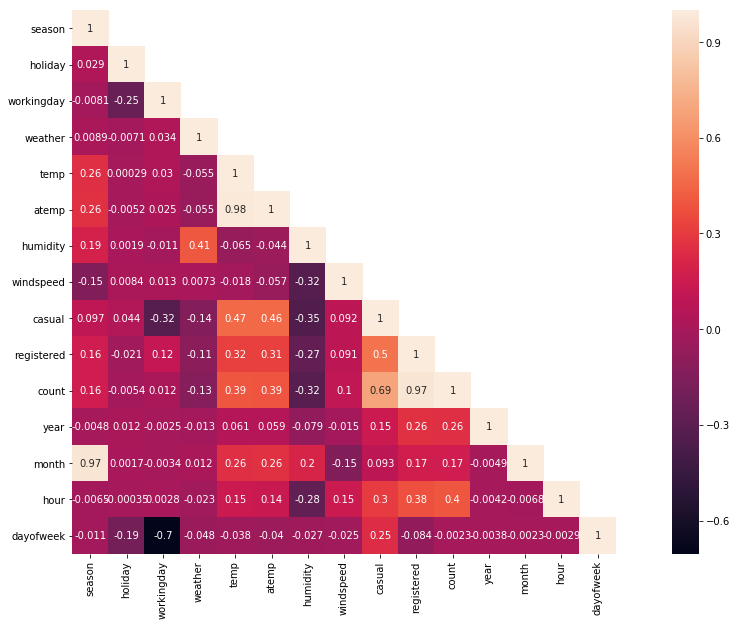

In [7]:
mask = np.array(train.corr())
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(train.corr(), mask=mask, square=True,annot=True)

Highest correlation observed between:
- season and month
- temperature and atemp
- number of casual/registered and count
- temperature and count

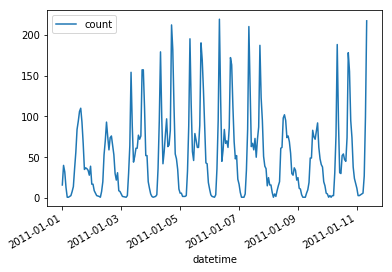

In [8]:
train[:24*10].plot(x='datetime', y='count')

In [9]:
dummy_fields = ['season', 'weather', 'holiday', 'workingday', 'hour', 'month', 'dayofweek']
for each in dummy_fields:
    dummies = pd.get_dummies(train[each], prefix=each, drop_first=False)
    train = pd.concat([train, dummies], axis=1)
    
for each in dummy_fields:
    dummies = pd.get_dummies(test[each], prefix=each, drop_first=False)
    test = pd.concat([test, dummies], axis=1)

fields_to_drop = ['season', 'weather', 'atemp',
                  'holiday', 'workingday', 'datetime', 'year']
data = train.drop(fields_to_drop, axis=1)
test_datetime = test['datetime']
test_data = test.drop(fields_to_drop, axis=1)
print(data.shape)
print(test_data.shape)

(10886, 64)
(6493, 61)


In [10]:
# scaling
'''quant_features = ['casual', 'registered', 'count', 'temp', 'humidity', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

print(scaled_features)
    ''' 
# Separate the data into features and targets
target_fields = ['count', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]


In [11]:
# Holding out the last 60 days or so of the remaining data as a validation set
X_train, y_train = features[:-60*24], targets[:-60*24]
X_val, y_val = features[-60*24:], targets[-60*24:]

## Model training
### 1. Decision Tree regression

In [12]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

decisionTree = DecisionTreeRegressor()

decisionTree.fit(X = X_train, y = y_train)
pred_tree = decisionTree.predict(X = X_train)

print("RMSLE on training data for a single Decision Tree with default parameters: {:.4f}".format(np.sqrt(mean_squared_log_error(y_train, pred_tree))))
# RMSLSE: 0.01078 - looks like a single Decision Tree with default parameters overfit to the train dataset
print('Probable overfitting')

decisionTree2 = DecisionTreeRegressor(max_depth=10)
decisionTree2.fit(X = X_train, y = y_train)
pred_tree2 = decisionTree2.predict(X = X_train)

print("RMSLE on training data for a single Decision Tree with maximum depth 10: {:.4f}".format(np.sqrt(mean_squared_log_error(y_train, pred_tree2))))

RMSLE on training data for a single Decision Tree with default parameters: 0.0109
Probable overfitting
RMSLE on training data for a single Decision Tree with maximum depth 10: 0.4827


### 2. Random Forest regression

In [13]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

randomForest = RandomForestRegressor(n_estimators=100)

randomForest.fit(X = X_train, y = y_train)
pred_rf = randomForest.predict(X = X_train)

rmsle = np.sqrt(mean_squared_log_error(y_train, pred_rf))
print("RMSLE on training data for Random Forest: {:.4f}".format(rmsle))

RMSLE on training data for Random Forest: 0.2169


### 2.1 Predictions for Validation Data


In [14]:
pred_val = randomForest.predict(X = X_val)

count = y_val['count']

pred=[]
for i in pred_val:
    pred.append(i[0])
    
prediction = pd.DataFrame({
        "count": count,
        "pred": pred
})

prediction.head()

,count,pred
9446,94,80.45
9447,45,36.64
9448,21,16.25
9449,13,10.07
9450,7,7.50


### 2.2 Predictions for test data


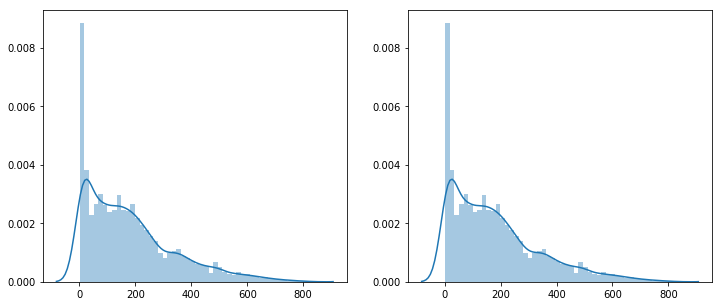

In [15]:
predsTest = randomForest.predict(X= test_data)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)


Predictions = []
for i in predsTest:
    Predictions.append(i[0])
    
tain_y = []
for i in predsTest:
    tain_y.append(i[0])

sn.distplot(tain_y, ax=ax1, bins=50)
sn.distplot(Predictions, ax=ax2, bins=50)

In [16]:
submission = pd.DataFrame({
        "datetime": test_datetime,
        "count": Predictions
    })
submission.to_csv('submission.csv', index=False)